## Imports and Seed Setting

In [1]:
# imports
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.7.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Hyperparams of the competition


In [3]:
c_telescope = 1152
sbm_telescope = int(1152*0.75)  #864

## Import and Preprocess the data

In [4]:
dataset = pd.read_csv('Training.csv')

In [5]:
# split into test and training datasets
test_size = int(dataset.shape[0]//10) # size of the test set is 10% of the training

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

In [6]:
#normalize the data

# choice of scaler
scaler = MinMaxScaler()

# fitting the scaler
scaler.fit(X_train_raw)

#transform X_train_raw and X_test_raw
X_pp_train = scaler.transform(X_train_raw)
X_pp_test = scaler.transform(X_test_raw)

# scaler returns numpy arrays (type = ndarray). Reconvert to dataframe for better plotting
data = np.concatenate((X_pp_train,X_pp_test))
data = pd.DataFrame(data, columns = dataset.columns)
X_pp_train = data.iloc[:-test_size]
X_pp_test = data.iloc[-test_size:]

In [7]:
# save the scaler
scaler_dir = 'vars/scalers'
if not os.path.exists(scaler_dir):
    os.makedirs(scaler_dir)

scaler_path = os.path.join(scaler_dir, 'min_max_scaler.gz')
joblib.dump(scaler, scaler_path)

['vars/scalers\\min_max_scaler.gz']

## Create Sequences

In [166]:
# First objective should be to predict the next quarter of test length. You can look at the instructions for the competition for 
# more information. So the total length to predict is c_telescope = 1152. In the first part of the competition we must predict 3 
# quarters of the total test sequences, i.e. 3/4 * 1152 = 864. One single quarter is made up of 1152/4 = 288. I believe, whatever
# the final structure of the model, that we could firs predict a quarter and then recgressively predict the rest.

quarter_tel = (1152//4) #288

# We can try to predict the quarter in 4 steps of 36

reg = 4
telescope = int(quarter_tel//4) #72
assert quarter_tel%4 == 0

# target labels are all the labels
target_labels = dataset.columns

# Hyper parameters for how to build the sequences. The total length of the dataset is 68528, so quite large. I would take the
# usual length to start with. We will obtain a very large number of sequences. Note that in 
# the inspection of the data the beginning of the sequence seemed quite different from the later evolution. One could consider removing 
# the first part as a possibility. 

window = 20
stride = 2

In [167]:
# build sequence function
def build_sequences(df, target_labels=['pollution'], window=200, stride = 20):
    # check to avoid errrors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values #copy() makes a deep copy
    temp_labels = df[target_labels].copy().values
    need_4_padding = len(df)%window != 0
    
    if(need_4_padding):
        padding_len = window-len(df)%window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_labels.shape[1]), dtype='float64')
        temp_labels = np.concatenate((padding, temp_labels))
        assert len(temp_df)%window == 0
        
    for idx in np.arange(0, len(temp_df)-window, stride):
        dataset.append(temp_df[idx:idx+window])
    dataset = np.array(dataset)
    return dataset

In [168]:
X_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )
X_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )

In [169]:
# Inspect random sequence

# plotting function 
def inspect_multivariate(X, columns, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        # print(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+1))
    plt.show()    

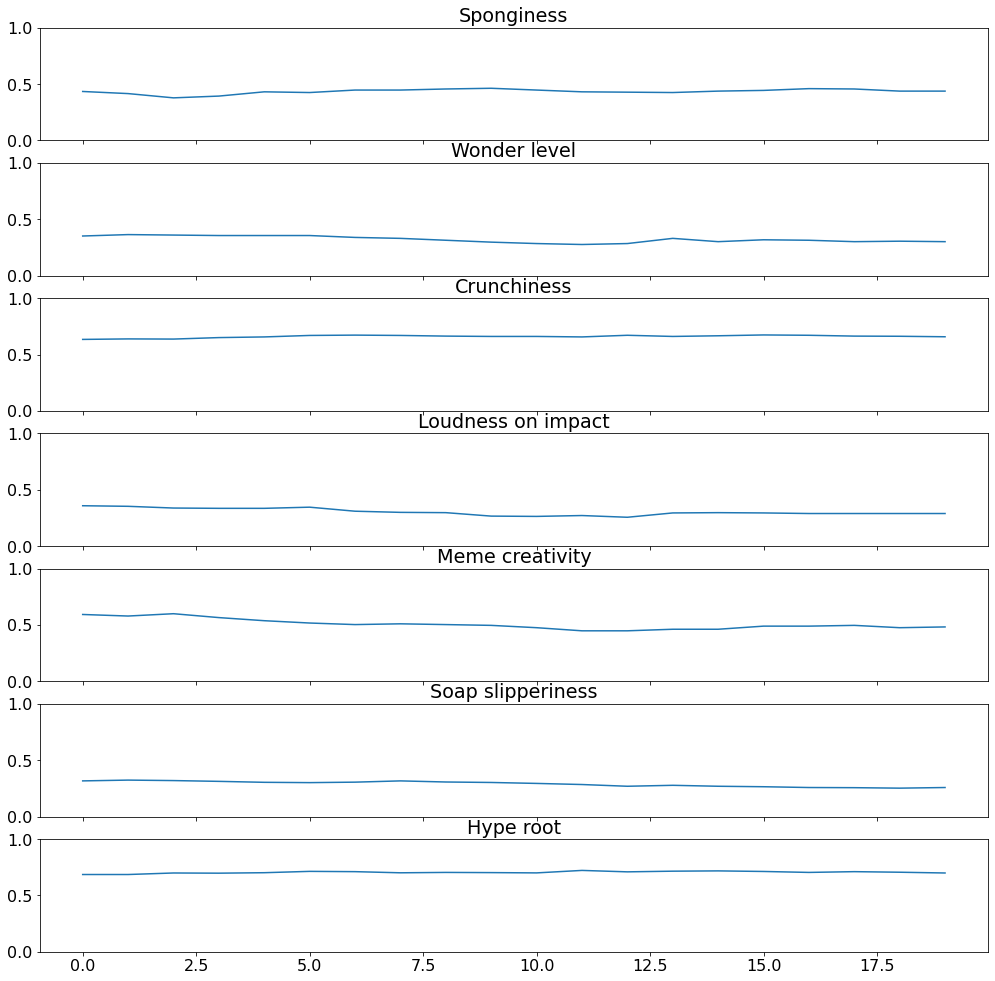

In [170]:
# inspect training sequence
inspect_multivariate(X_train, target_labels)

## Autoencoder Model

In [171]:
n_features = target_labels.size
input_shape = (window, n_features)

In [172]:
n_features

7

In [221]:
from tensorflow.keras.layers import LSTM, Dense

def build_autoencoder(window, n_features):
    input_shape=(window, n_features)
    encoder = tfk.models.Sequential([
        tfkl.Bidirectional(LSTM(64, return_sequences = True, name='encoder_1')),
        tfkl.Bidirectional(LSTM(32, return_sequences = True, name='encoder_2')),
        tfkl.Bidirectional(LSTM(16, return_sequences=False, name='encoder_3'))
    ],
        name ='Encoder'
    )
    
    latent_representation = tfkl.RepeatVector(window, name='latent_representation')
    
    decoder = tfk.models.Sequential([
        tfkl.Bidirectional(LSTM(16, return_sequences = True, name='decoder_1')),
        tfkl.Bidirectional(LSTM(32, return_sequences=True, name='decoder_2')),
        tfkl.Bidirectional(LSTM(64, return_sequences=True, name='decoder_3')),
        tfkl.TimeDistributed(Dense(n_features))
    ], name='decoder')
    
    autoencoder_input = tfkl.Input(shape=(input_shape), name='encoder_input')
    z = encoder(autoencoder_input)
    z = latent_representation(z)
    autoencoder = tfk.Model(inputs=autoencoder_input, outputs=decoder(z), name ='Autoencoder')
    return encoder, decoder, autoencoder

In [222]:
X_train = build_sequences(
    X_pp_train,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )
X_test = build_sequences(
    X_pp_test,
    target_labels=target_labels,
    window=window,
    stride=stride,
    )

In [223]:
enc, dec, ae = build_autoencoder(window, n_features)

In [224]:
ae.summary(expand_nested=True)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 20, 7)]           0         
                                                                 
 Encoder (Sequential)        (None, 32)                88448     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| bidirectional_6 (Bidirectio  (None, 20, 128)        36864     |
| nal)                                                          |
|                                                               |
| bidirectional_7 (Bidirectio  (None, 20, 64)         41216     |
| nal)                                                          |
|                                                               |
| bidirectional_8 (Bidirectio  (None, 32)             10368     |
| nal)                                                          |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [225]:
# compile the autoencoder
ae.compile(
    optimizer = tf.optimizers.Adam(learning_rate=1e-3),
    loss='mse', # because we have two populations...
    metrics = ['mse', 'mae']
)

In [226]:
history=ae.fit(
    X_train,
    X_train, #obviously because it is an autoencoder
    batch_size = 256,
    epochs=1000,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/1000
109/109 [==============================] - 18s 64ms/step - loss: 0.0263 - mse: 0.0263 - mae: 0.1132 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0582 - lr: 0.0010
Epoch 2/1000
109/109 [==============================] - 4s 40ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0407 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0372 - lr: 0.0010
Epoch 3/1000
109/109 [==============================] - 4s 41ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0304 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0282 - lr: 0.0010
Epoch 4/1000
109/109 [==============================] - 4s 41ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0260 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0390 - lr: 0.0010
Epoch 5/1000
109/109 [==============================] - 4s 39ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0255 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0254 - lr: 0.0010
Epoch 6/1000
109/109 [==============================] - 4s 39ms/step - loss: 0.0013 - mse: 0.0013 -

109/109 [==============================] - 4s 40ms/step - loss: 7.7435e-04 - mse: 7.7435e-04 - mae: 0.0189 - val_loss: 9.7933e-04 - val_mse: 9.7933e-04 - val_mae: 0.0201 - lr: 1.5625e-05
Epoch 44/1000
109/109 [==============================] - 4s 40ms/step - loss: 7.7393e-04 - mse: 7.7393e-04 - mae: 0.0189 - val_loss: 9.7876e-04 - val_mse: 9.7876e-04 - val_mae: 0.0201 - lr: 1.5625e-05
Epoch 45/1000
109/109 [==============================] - 4s 40ms/step - loss: 7.7340e-04 - mse: 7.7340e-04 - mae: 0.0189 - val_loss: 9.7705e-04 - val_mse: 9.7705e-04 - val_mae: 0.0200 - lr: 1.5625e-05
Epoch 46/1000
109/109 [==============================] - 4s 40ms/step - loss: 7.7285e-04 - mse: 7.7285e-04 - mae: 0.0189 - val_loss: 9.7708e-04 - val_mse: 9.7708e-04 - val_mae: 0.0200 - lr: 1.0000e-05
Epoch 47/1000
109/109 [==============================] - 4s 40ms/step - loss: 7.7247e-04 - mse: 7.7247e-04 - mae: 0.0189 - val_loss: 9.7756e-04 - val_mse: 9.7756e-04 - val_mae: 0.0200 - lr: 1.0000e-05
Epoch 48/

Epoch 84/1000
109/109 [==============================] - 4s 41ms/step - loss: 7.3665e-04 - mse: 7.3665e-04 - mae: 0.0184 - val_loss: 9.1389e-04 - val_mse: 9.1389e-04 - val_mae: 0.0194 - lr: 1.0000e-05
Epoch 85/1000
109/109 [==============================] - 4s 41ms/step - loss: 7.3495e-04 - mse: 7.3495e-04 - mae: 0.0184 - val_loss: 9.0976e-04 - val_mse: 9.0976e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 86/1000
109/109 [==============================] - 4s 40ms/step - loss: 7.3313e-04 - mse: 7.3313e-04 - mae: 0.0183 - val_loss: 9.0893e-04 - val_mse: 9.0893e-04 - val_mae: 0.0193 - lr: 1.0000e-05
Epoch 87/1000
109/109 [==============================] - 4s 38ms/step - loss: 7.3134e-04 - mse: 7.3134e-04 - mae: 0.0183 - val_loss: 9.0511e-04 - val_mse: 9.0511e-04 - val_mae: 0.0192 - lr: 1.0000e-05
Epoch 88/1000
109/109 [==============================] - 4s 38ms/step - loss: 7.2935e-04 - mse: 7.2935e-04 - mae: 0.0183 - val_loss: 8.9989e-04 - val_mse: 8.9989e-04 - val_mae: 0.0192 - lr: 1.0000

Epoch 125/1000
109/109 [==============================] - 4s 39ms/step - loss: 6.7366e-04 - mse: 6.7366e-04 - mae: 0.0176 - val_loss: 8.1115e-04 - val_mse: 8.1115e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 126/1000
109/109 [==============================] - 4s 41ms/step - loss: 6.7285e-04 - mse: 6.7285e-04 - mae: 0.0175 - val_loss: 8.0984e-04 - val_mse: 8.0984e-04 - val_mae: 0.0181 - lr: 1.0000e-05
Epoch 127/1000
109/109 [==============================] - 4s 41ms/step - loss: 6.7215e-04 - mse: 6.7215e-04 - mae: 0.0175 - val_loss: 8.0903e-04 - val_mse: 8.0903e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 128/1000
109/109 [==============================] - 5s 41ms/step - loss: 6.7136e-04 - mse: 6.7136e-04 - mae: 0.0175 - val_loss: 8.0814e-04 - val_mse: 8.0814e-04 - val_mae: 0.0180 - lr: 1.0000e-05
Epoch 129/1000
109/109 [==============================] - 5s 42ms/step - loss: 6.7063e-04 - mse: 6.7063e-04 - mae: 0.0175 - val_loss: 8.0741e-04 - val_mse: 8.0741e-04 - val_mae: 0.0180 - lr: 1

109/109 [==============================] - 4s 41ms/step - loss: 6.5009e-04 - mse: 6.5009e-04 - mae: 0.0172 - val_loss: 7.8444e-04 - val_mse: 7.8444e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 166/1000
109/109 [==============================] - 4s 41ms/step - loss: 6.4948e-04 - mse: 6.4948e-04 - mae: 0.0172 - val_loss: 7.8455e-04 - val_mse: 7.8455e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 167/1000
109/109 [==============================] - 5s 42ms/step - loss: 6.4891e-04 - mse: 6.4891e-04 - mae: 0.0172 - val_loss: 7.8423e-04 - val_mse: 7.8423e-04 - val_mae: 0.0177 - lr: 1.0000e-05
Epoch 168/1000
109/109 [==============================] - 4s 40ms/step - loss: 6.4832e-04 - mse: 6.4832e-04 - mae: 0.0172 - val_loss: 7.8331e-04 - val_mse: 7.8331e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch 169/1000
109/109 [==============================] - 4s 39ms/step - loss: 6.4772e-04 - mse: 6.4772e-04 - mae: 0.0172 - val_loss: 7.8173e-04 - val_mse: 7.8173e-04 - val_mae: 0.0176 - lr: 1.0000e-05
Epoch

Epoch 206/1000
109/109 [==============================] - 5s 42ms/step - loss: 6.1533e-04 - mse: 6.1533e-04 - mae: 0.0167 - val_loss: 7.5047e-04 - val_mse: 7.5047e-04 - val_mae: 0.0172 - lr: 1.0000e-05
Epoch 207/1000
109/109 [==============================] - 4s 41ms/step - loss: 6.1440e-04 - mse: 6.1440e-04 - mae: 0.0167 - val_loss: 7.4950e-04 - val_mse: 7.4950e-04 - val_mae: 0.0172 - lr: 1.0000e-05
Epoch 208/1000
109/109 [==============================] - 4s 41ms/step - loss: 6.1344e-04 - mse: 6.1344e-04 - mae: 0.0167 - val_loss: 7.4804e-04 - val_mse: 7.4804e-04 - val_mae: 0.0172 - lr: 1.0000e-05
Epoch 209/1000
109/109 [==============================] - 5s 42ms/step - loss: 6.1251e-04 - mse: 6.1251e-04 - mae: 0.0166 - val_loss: 7.4705e-04 - val_mse: 7.4705e-04 - val_mae: 0.0172 - lr: 1.0000e-05
Epoch 210/1000
109/109 [==============================] - 5s 41ms/step - loss: 6.1166e-04 - mse: 6.1166e-04 - mae: 0.0166 - val_loss: 7.4664e-04 - val_mse: 7.4664e-04 - val_mae: 0.0172 - lr: 1

109/109 [==============================] - 4s 41ms/step - loss: 5.9416e-04 - mse: 5.9416e-04 - mae: 0.0163 - val_loss: 7.3011e-04 - val_mse: 7.3011e-04 - val_mae: 0.0169 - lr: 1.0000e-05
Epoch 247/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.9387e-04 - mse: 5.9387e-04 - mae: 0.0163 - val_loss: 7.2988e-04 - val_mse: 7.2988e-04 - val_mae: 0.0169 - lr: 1.0000e-05
Epoch 248/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.9358e-04 - mse: 5.9358e-04 - mae: 0.0163 - val_loss: 7.2998e-04 - val_mse: 7.2998e-04 - val_mae: 0.0169 - lr: 1.0000e-05
Epoch 249/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.9337e-04 - mse: 5.9337e-04 - mae: 0.0163 - val_loss: 7.2986e-04 - val_mse: 7.2986e-04 - val_mae: 0.0169 - lr: 1.0000e-05
Epoch 250/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.9305e-04 - mse: 5.9305e-04 - mae: 0.0163 - val_loss: 7.2944e-04 - val_mse: 7.2944e-04 - val_mae: 0.0169 - lr: 1.0000e-05
Epoch

Epoch 287/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.8593e-04 - mse: 5.8593e-04 - mae: 0.0162 - val_loss: 7.2159e-04 - val_mse: 7.2159e-04 - val_mae: 0.0167 - lr: 1.0000e-05
Epoch 288/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.8579e-04 - mse: 5.8579e-04 - mae: 0.0162 - val_loss: 7.2133e-04 - val_mse: 7.2133e-04 - val_mae: 0.0168 - lr: 1.0000e-05
Epoch 289/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.8564e-04 - mse: 5.8564e-04 - mae: 0.0162 - val_loss: 7.2138e-04 - val_mse: 7.2138e-04 - val_mae: 0.0168 - lr: 1.0000e-05
Epoch 290/1000
109/109 [==============================] - 4s 38ms/step - loss: 5.8544e-04 - mse: 5.8544e-04 - mae: 0.0162 - val_loss: 7.2142e-04 - val_mse: 7.2142e-04 - val_mae: 0.0168 - lr: 1.0000e-05
Epoch 291/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.8535e-04 - mse: 5.8535e-04 - mae: 0.0162 - val_loss: 7.2094e-04 - val_mse: 7.2094e-04 - val_mae: 0.0167 - lr: 1

109/109 [==============================] - 4s 39ms/step - loss: 5.7960e-04 - mse: 5.7960e-04 - mae: 0.0161 - val_loss: 7.1426e-04 - val_mse: 7.1426e-04 - val_mae: 0.0166 - lr: 1.0000e-05
Epoch 328/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.7945e-04 - mse: 5.7945e-04 - mae: 0.0161 - val_loss: 7.1400e-04 - val_mse: 7.1400e-04 - val_mae: 0.0166 - lr: 1.0000e-05
Epoch 329/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.7935e-04 - mse: 5.7935e-04 - mae: 0.0161 - val_loss: 7.1367e-04 - val_mse: 7.1367e-04 - val_mae: 0.0166 - lr: 1.0000e-05
Epoch 330/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.7912e-04 - mse: 5.7912e-04 - mae: 0.0160 - val_loss: 7.1423e-04 - val_mse: 7.1422e-04 - val_mae: 0.0166 - lr: 1.0000e-05
Epoch 331/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.7896e-04 - mse: 5.7896e-04 - mae: 0.0160 - val_loss: 7.1345e-04 - val_mse: 7.1345e-04 - val_mae: 0.0166 - lr: 1.0000e-05
Epoch

Epoch 368/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.7159e-04 - mse: 5.7159e-04 - mae: 0.0159 - val_loss: 7.0452e-04 - val_mse: 7.0452e-04 - val_mae: 0.0165 - lr: 1.0000e-05
Epoch 369/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.7137e-04 - mse: 5.7137e-04 - mae: 0.0159 - val_loss: 7.0449e-04 - val_mse: 7.0449e-04 - val_mae: 0.0165 - lr: 1.0000e-05
Epoch 370/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.7115e-04 - mse: 5.7115e-04 - mae: 0.0159 - val_loss: 7.0365e-04 - val_mse: 7.0365e-04 - val_mae: 0.0165 - lr: 1.0000e-05
Epoch 371/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.7083e-04 - mse: 5.7083e-04 - mae: 0.0159 - val_loss: 7.0328e-04 - val_mse: 7.0328e-04 - val_mae: 0.0165 - lr: 1.0000e-05
Epoch 372/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.7064e-04 - mse: 5.7064e-04 - mae: 0.0159 - val_loss: 7.0314e-04 - val_mse: 7.0314e-04 - val_mae: 0.0165 - lr: 1

109/109 [==============================] - 4s 41ms/step - loss: 5.5826e-04 - mse: 5.5826e-04 - mae: 0.0157 - val_loss: 6.8533e-04 - val_mse: 6.8533e-04 - val_mae: 0.0162 - lr: 1.0000e-05
Epoch 409/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.5783e-04 - mse: 5.5783e-04 - mae: 0.0157 - val_loss: 6.8495e-04 - val_mse: 6.8495e-04 - val_mae: 0.0162 - lr: 1.0000e-05
Epoch 410/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.5744e-04 - mse: 5.5744e-04 - mae: 0.0157 - val_loss: 6.8418e-04 - val_mse: 6.8418e-04 - val_mae: 0.0162 - lr: 1.0000e-05
Epoch 411/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.5698e-04 - mse: 5.5698e-04 - mae: 0.0157 - val_loss: 6.8353e-04 - val_mse: 6.8353e-04 - val_mae: 0.0162 - lr: 1.0000e-05
Epoch 412/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.5663e-04 - mse: 5.5663e-04 - mae: 0.0157 - val_loss: 6.8324e-04 - val_mse: 6.8324e-04 - val_mae: 0.0162 - lr: 1.0000e-05
Epoch

Epoch 449/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.4558e-04 - mse: 5.4558e-04 - mae: 0.0155 - val_loss: 6.6605e-04 - val_mse: 6.6605e-04 - val_mae: 0.0160 - lr: 1.0000e-05
Epoch 450/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.4546e-04 - mse: 5.4546e-04 - mae: 0.0155 - val_loss: 6.6613e-04 - val_mse: 6.6613e-04 - val_mae: 0.0160 - lr: 1.0000e-05
Epoch 451/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.4533e-04 - mse: 5.4533e-04 - mae: 0.0155 - val_loss: 6.6558e-04 - val_mse: 6.6558e-04 - val_mae: 0.0160 - lr: 1.0000e-05
Epoch 452/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.4515e-04 - mse: 5.4515e-04 - mae: 0.0155 - val_loss: 6.6594e-04 - val_mse: 6.6594e-04 - val_mae: 0.0160 - lr: 1.0000e-05
Epoch 453/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.4503e-04 - mse: 5.4503e-04 - mae: 0.0155 - val_loss: 6.6518e-04 - val_mse: 6.6518e-04 - val_mae: 0.0160 - lr: 1

109/109 [==============================] - 4s 41ms/step - loss: 5.4093e-04 - mse: 5.4093e-04 - mae: 0.0154 - val_loss: 6.5839e-04 - val_mse: 6.5839e-04 - val_mae: 0.0159 - lr: 1.0000e-05
Epoch 490/1000
109/109 [==============================] - 4s 38ms/step - loss: 5.4085e-04 - mse: 5.4085e-04 - mae: 0.0154 - val_loss: 6.5816e-04 - val_mse: 6.5816e-04 - val_mae: 0.0159 - lr: 1.0000e-05
Epoch 491/1000
109/109 [==============================] - 4s 37ms/step - loss: 5.4073e-04 - mse: 5.4073e-04 - mae: 0.0154 - val_loss: 6.5799e-04 - val_mse: 6.5799e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 492/1000
109/109 [==============================] - 4s 37ms/step - loss: 5.4066e-04 - mse: 5.4066e-04 - mae: 0.0154 - val_loss: 6.5777e-04 - val_mse: 6.5777e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 493/1000
109/109 [==============================] - 4s 38ms/step - loss: 5.4056e-04 - mse: 5.4056e-04 - mae: 0.0154 - val_loss: 6.5760e-04 - val_mse: 6.5760e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch

Epoch 530/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.3692e-04 - mse: 5.3692e-04 - mae: 0.0154 - val_loss: 6.5200e-04 - val_mse: 6.5200e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 531/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.3690e-04 - mse: 5.3690e-04 - mae: 0.0154 - val_loss: 6.5225e-04 - val_mse: 6.5225e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 532/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.3671e-04 - mse: 5.3671e-04 - mae: 0.0154 - val_loss: 6.5179e-04 - val_mse: 6.5179e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 533/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.3660e-04 - mse: 5.3660e-04 - mae: 0.0154 - val_loss: 6.5161e-04 - val_mse: 6.5161e-04 - val_mae: 0.0158 - lr: 1.0000e-05
Epoch 534/1000
109/109 [==============================] - 4s 41ms/step - loss: 5.3642e-04 - mse: 5.3642e-04 - mae: 0.0153 - val_loss: 6.5160e-04 - val_mse: 6.5160e-04 - val_mae: 0.0158 - lr: 1

109/109 [==============================] - 4s 40ms/step - loss: 5.3160e-04 - mse: 5.3160e-04 - mae: 0.0153 - val_loss: 6.4354e-04 - val_mse: 6.4354e-04 - val_mae: 0.0157 - lr: 1.0000e-05
Epoch 571/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.3147e-04 - mse: 5.3147e-04 - mae: 0.0153 - val_loss: 6.4317e-04 - val_mse: 6.4317e-04 - val_mae: 0.0157 - lr: 1.0000e-05
Epoch 572/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.3124e-04 - mse: 5.3124e-04 - mae: 0.0153 - val_loss: 6.4314e-04 - val_mse: 6.4314e-04 - val_mae: 0.0157 - lr: 1.0000e-05
Epoch 573/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.3104e-04 - mse: 5.3104e-04 - mae: 0.0153 - val_loss: 6.4242e-04 - val_mse: 6.4242e-04 - val_mae: 0.0157 - lr: 1.0000e-05
Epoch 574/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.3082e-04 - mse: 5.3082e-04 - mae: 0.0153 - val_loss: 6.4197e-04 - val_mse: 6.4197e-04 - val_mae: 0.0156 - lr: 1.0000e-05
Epoch

Epoch 611/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.1994e-04 - mse: 5.1994e-04 - mae: 0.0151 - val_loss: 6.2426e-04 - val_mse: 6.2426e-04 - val_mae: 0.0154 - lr: 1.0000e-05
Epoch 612/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.1958e-04 - mse: 5.1958e-04 - mae: 0.0151 - val_loss: 6.2342e-04 - val_mse: 6.2342e-04 - val_mae: 0.0154 - lr: 1.0000e-05
Epoch 613/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.1907e-04 - mse: 5.1907e-04 - mae: 0.0151 - val_loss: 6.2287e-04 - val_mse: 6.2287e-04 - val_mae: 0.0154 - lr: 1.0000e-05
Epoch 614/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.1869e-04 - mse: 5.1869e-04 - mae: 0.0151 - val_loss: 6.2191e-04 - val_mse: 6.2190e-04 - val_mae: 0.0154 - lr: 1.0000e-05
Epoch 615/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.1819e-04 - mse: 5.1819e-04 - mae: 0.0151 - val_loss: 6.2172e-04 - val_mse: 6.2172e-04 - val_mae: 0.0154 - lr: 1

109/109 [==============================] - 4s 40ms/step - loss: 5.0281e-04 - mse: 5.0281e-04 - mae: 0.0148 - val_loss: 5.9636e-04 - val_mse: 5.9636e-04 - val_mae: 0.0151 - lr: 1.0000e-05
Epoch 652/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.0247e-04 - mse: 5.0247e-04 - mae: 0.0148 - val_loss: 5.9591e-04 - val_mse: 5.9591e-04 - val_mae: 0.0150 - lr: 1.0000e-05
Epoch 653/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.0222e-04 - mse: 5.0222e-04 - mae: 0.0148 - val_loss: 5.9530e-04 - val_mse: 5.9530e-04 - val_mae: 0.0150 - lr: 1.0000e-05
Epoch 654/1000
109/109 [==============================] - 4s 40ms/step - loss: 5.0197e-04 - mse: 5.0197e-04 - mae: 0.0148 - val_loss: 5.9527e-04 - val_mse: 5.9527e-04 - val_mae: 0.0150 - lr: 1.0000e-05
Epoch 655/1000
109/109 [==============================] - 4s 39ms/step - loss: 5.0170e-04 - mse: 5.0170e-04 - mae: 0.0148 - val_loss: 5.9482e-04 - val_mse: 5.9482e-04 - val_mae: 0.0150 - lr: 1.0000e-05
Epoch

Epoch 692/1000
109/109 [==============================] - 4s 41ms/step - loss: 4.9594e-04 - mse: 4.9594e-04 - mae: 0.0147 - val_loss: 5.8561e-04 - val_mse: 5.8561e-04 - val_mae: 0.0149 - lr: 1.0000e-05
Epoch 693/1000
109/109 [==============================] - 4s 41ms/step - loss: 4.9572e-04 - mse: 4.9572e-04 - mae: 0.0147 - val_loss: 5.8595e-04 - val_mse: 5.8595e-04 - val_mae: 0.0149 - lr: 1.0000e-05
Epoch 694/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9563e-04 - mse: 4.9563e-04 - mae: 0.0147 - val_loss: 5.8607e-04 - val_mse: 5.8607e-04 - val_mae: 0.0149 - lr: 1.0000e-05
Epoch 695/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9560e-04 - mse: 4.9560e-04 - mae: 0.0147 - val_loss: 5.8547e-04 - val_mse: 5.8547e-04 - val_mae: 0.0149 - lr: 1.0000e-05
Epoch 696/1000
109/109 [==============================] - 4s 39ms/step - loss: 4.9547e-04 - mse: 4.9547e-04 - mae: 0.0147 - val_loss: 5.8535e-04 - val_mse: 5.8535e-04 - val_mae: 0.0149 - lr: 1

109/109 [==============================] - 4s 39ms/step - loss: 4.9252e-04 - mse: 4.9252e-04 - mae: 0.0147 - val_loss: 5.8061e-04 - val_mse: 5.8061e-04 - val_mae: 0.0148 - lr: 1.0000e-05
Epoch 733/1000
109/109 [==============================] - 4s 38ms/step - loss: 4.9251e-04 - mse: 4.9251e-04 - mae: 0.0147 - val_loss: 5.8047e-04 - val_mse: 5.8047e-04 - val_mae: 0.0148 - lr: 1.0000e-05
Epoch 734/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9243e-04 - mse: 4.9243e-04 - mae: 0.0147 - val_loss: 5.8070e-04 - val_mse: 5.8070e-04 - val_mae: 0.0148 - lr: 1.0000e-05
Epoch 735/1000
109/109 [==============================] - 5s 41ms/step - loss: 4.9238e-04 - mse: 4.9238e-04 - mae: 0.0147 - val_loss: 5.8066e-04 - val_mse: 5.8066e-04 - val_mae: 0.0148 - lr: 1.0000e-05
Epoch 736/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9234e-04 - mse: 4.9234e-04 - mae: 0.0147 - val_loss: 5.8066e-04 - val_mse: 5.8066e-04 - val_mae: 0.0148 - lr: 1.0000e-05
Epoch

Epoch 773/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9025e-04 - mse: 4.9025e-04 - mae: 0.0146 - val_loss: 5.7741e-04 - val_mse: 5.7741e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 774/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9022e-04 - mse: 4.9022e-04 - mae: 0.0146 - val_loss: 5.7753e-04 - val_mse: 5.7753e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 775/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9017e-04 - mse: 4.9017e-04 - mae: 0.0146 - val_loss: 5.7742e-04 - val_mse: 5.7742e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 776/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9015e-04 - mse: 4.9015e-04 - mae: 0.0146 - val_loss: 5.7747e-04 - val_mse: 5.7747e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 777/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.9005e-04 - mse: 4.9005e-04 - mae: 0.0146 - val_loss: 5.7729e-04 - val_mse: 5.7729e-04 - val_mae: 0.0147 - lr: 1

109/109 [==============================] - 5s 42ms/step - loss: 4.8852e-04 - mse: 4.8852e-04 - mae: 0.0146 - val_loss: 5.7537e-04 - val_mse: 5.7537e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 814/1000
109/109 [==============================] - 5s 43ms/step - loss: 4.8848e-04 - mse: 4.8848e-04 - mae: 0.0146 - val_loss: 5.7543e-04 - val_mse: 5.7543e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 815/1000
109/109 [==============================] - 5s 42ms/step - loss: 4.8833e-04 - mse: 4.8833e-04 - mae: 0.0146 - val_loss: 5.7508e-04 - val_mse: 5.7508e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 816/1000
109/109 [==============================] - 4s 41ms/step - loss: 4.8831e-04 - mse: 4.8831e-04 - mae: 0.0146 - val_loss: 5.7569e-04 - val_mse: 5.7569e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 817/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8833e-04 - mse: 4.8833e-04 - mae: 0.0146 - val_loss: 5.7503e-04 - val_mse: 5.7503e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch

Epoch 854/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8693e-04 - mse: 4.8693e-04 - mae: 0.0145 - val_loss: 5.7390e-04 - val_mse: 5.7390e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 855/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8692e-04 - mse: 4.8692e-04 - mae: 0.0145 - val_loss: 5.7317e-04 - val_mse: 5.7317e-04 - val_mae: 0.0146 - lr: 1.0000e-05
Epoch 856/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8689e-04 - mse: 4.8689e-04 - mae: 0.0145 - val_loss: 5.7330e-04 - val_mse: 5.7330e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 857/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8683e-04 - mse: 4.8683e-04 - mae: 0.0145 - val_loss: 5.7346e-04 - val_mse: 5.7346e-04 - val_mae: 0.0147 - lr: 1.0000e-05
Epoch 858/1000
109/109 [==============================] - 4s 40ms/step - loss: 4.8675e-04 - mse: 4.8675e-04 - mae: 0.0145 - val_loss: 5.7329e-04 - val_mse: 5.7329e-04 - val_mae: 0.0146 - lr: 1

## Evaluate Performance

In [239]:
# ae = tfk.models.load_model(os.path.join(models_dir, 'autoencoder_w20'))

# X_test = build_sequences(
#     X_pp_test,
#     target_labels=target_labels,
#     window=20,
#     stride=stride,
#     )

# predict the test set
predictions = ae.predict(X_test)

# calculate mean errors
mean_squared_error = tfk.metrics.mse(X_test.flatten(), predictions.flatten())
mean_absolute_error = tfk.metrics.mae(X_test.flatten(), predictions.flatten())

mean_absolute_error, mean_squared_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.019084947>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0008818924>)

In [ ]:
(<tf.Tensor: shape=(), dtype=float32, numpy=0.027423438>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0016423299>)

In [228]:
## inspect the performance of the model

def inspect_autoencoder(X, pred, columns):
    idx=np.random.randint(0, len(X))
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx, :, i], color='blue')
        axs[i].plot(np.arange(len(pred[0,:,i])), pred[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

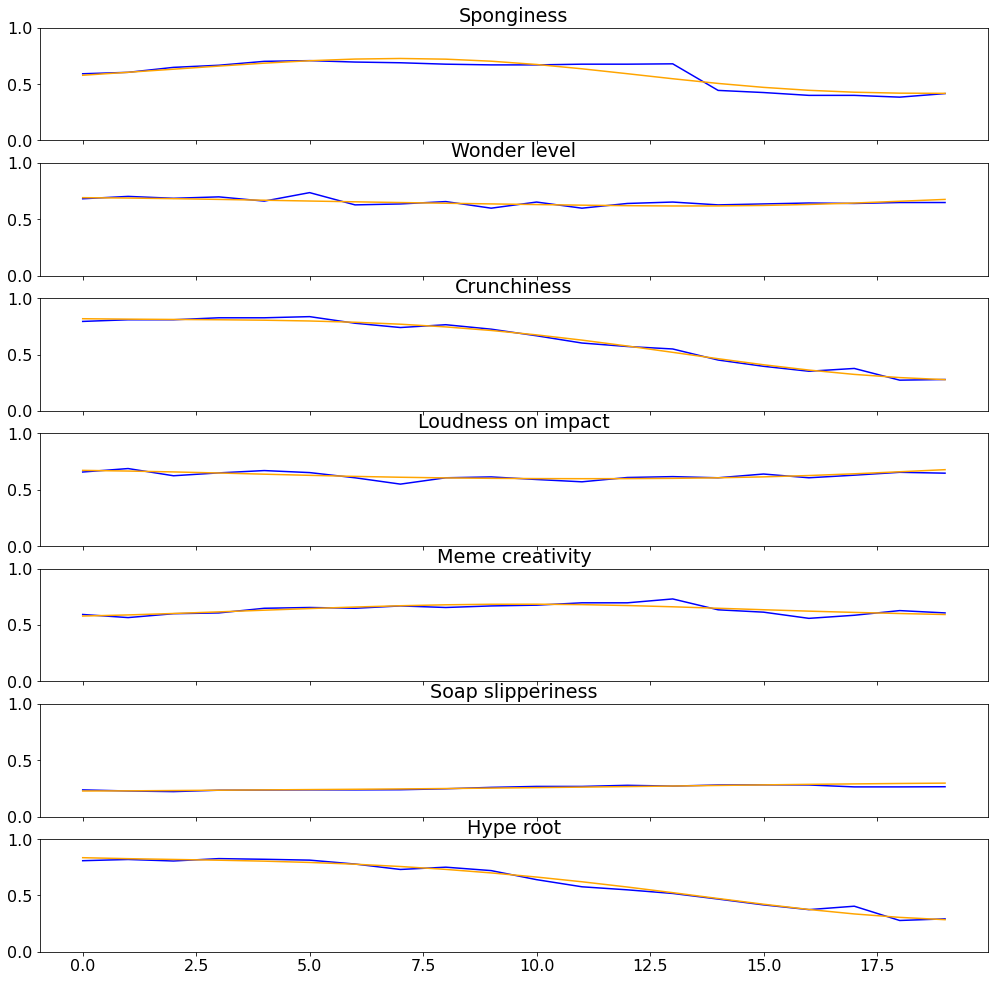

In [238]:
inspect_autoencoder(X_test, predictions, dataset.columns)

In [240]:
models_dir = 'models'
modelname = 'autoencoder_w20_0B'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

ae.save(os.path.join(models_dir, modelname))